# Temporal Topic Modeling on Research Papers

To analyze how research topics evolve over time by applying temporal topic modeling on a dataset of research papers and enhance insights through network analysis of citation dynamics.

## Table of contents
1. Introduction
    1. Purpose of the project
    1. Main assumptions
1. Dataset Collection
1. Model: LDA
    1. Preprocessing
    1. Exploratory Data Analysis
    1. Temporal Topic Modeling
    1. Visualization
    1. Evaluation of LDA
1. Model: BertTopic
    1. Preprocessing
    1. Exploratory Data Analysis
    1. Temporal Topic Modeling
    1. Visualization
    1. Evaluation of BertTopic
1. Summary

### 1.1. Purpose of the project

Choose a field (e.g., AI, climate change, biomedical research) to analyze.
Set the time frame (e.g., research papers published from 2001–2024).

### 1.2. Main assumptions
- BertTopic Modeling is better than LDA.
- How have topics emerged, evolved, or declined over time?
- What are the influential topics over the time?

### 2. Dataset Collection

Dataset Collection

Data Source:
 - arXiv: Use the API to fetch metadata and abstracts from selected categories (e.g., cs.AI, stat.ML).
- Download Link: [https://www.kaggle.com/datasets/Cornell-University/arxiv](https://www.kaggle.com/datasets/Cornell-University/arxiv)

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
import json

# https://arxiv.org/help/api/user-manual
category_map = {
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control'
}

data_file = 'dataset/arxiv/arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line
            
titles = []
abstracts = []
titles_abstracts = []
years = []
categories = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(ref[-4:]) 
        if 2000 < year <= 2024:
            categories.append(category_map[paper_dict.get('categories').split(" ")[0]])
            years.append(year)
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
            titles_abstracts.append(paper_dict.get('title') + '. ' + paper_dict.get('abstract'))
    except:
        pass # ignore papers without a year

(25956, 25956, 25956, 25956)

In [18]:
import pandas as pd

In [19]:
df = pd.DataFrame({
    'titles': titles,
    'abstract': abstracts,
    'titles_abstracts': titles_abstracts,
    'category': categories,
    'years': years
})

In [20]:
df.shape

(25956, 5)

In [23]:
df.head()

,titles,abstract,titles_abstracts,category,years
0,Capacity of a Multiple-Antenna Fading Channel ...,Given a multiple-input multiple-output (MIMO...,Capacity of a Multiple-Antenna Fading Channel ...,Information Theory,2009
1,The World as Evolving Information,This paper discusses the benefits of describ...,The World as Evolving Information. This pape...,Information Theory,2012
2,A Note on the Inapproximability of Correlation...,We consider inapproximability of the correla...,A Note on the Inapproximability of Correlation...,Machine Learning,2008
3,Nature-Inspired Interconnects for Self-Assembl...,Future nano-scale electronics built up from ...,Nature-Inspired Interconnects for Self-Assembl...,Hardware Architecture,2007
4,Space Time Codes from Permutation Codes,A new class of space time codes with high pe...,Space Time Codes from Permutation Codes. A n...,Information Theory,2006


### 3. Model: LDA

### 3.1. Preprocessing

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from sklearn.decomposition import LatentDirichletAllocation # LDA implementation

import pyLDAvis
import pyLDAvis.lda_model

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [30]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chandp20/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
def preprocess_text_token(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

def token_to_keywords(text):
    words = word_tokenize(text.lower())
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return keywords

In [34]:
df['title_abstract_tokens'] = df['titles_abstracts'].apply(preprocess_text_token)

In [37]:
df.head()

,titles,abstract,titles_abstracts,category,years,title_abstract_tokens
0,Capacity of a Multiple-Antenna Fading Channel ...,Given a multiple-input multiple-output (MIMO...,Capacity of a Multiple-Antenna Fading Channel ...,Information Theory,2009,capacity fading channel quantized precoding ma...
1,The World as Evolving Information,This paper discusses the benefits of describ...,The World as Evolving Information. This pape...,Information Theory,2012,world evolving information paper discusses ben...
2,A Note on the Inapproximability of Correlation...,We consider inapproximability of the correla...,A Note on the Inapproximability of Correlation...,Machine Learning,2008,note inapproximability correlation clustering ...
3,Nature-Inspired Interconnects for Self-Assembl...,Future nano-scale electronics built up from ...,Nature-Inspired Interconnects for Self-Assembl...,Hardware Architecture,2007,interconnects design future electronics built ...
4,Space Time Codes from Permutation Codes,A new class of space time codes with high pe...,Space Time Codes from Permutation Codes. A n...,Information Theory,2006,space time code permutation code new class spa...


In [44]:
# Initialize a dictionary to store keyword frequencies per year
keyword_freq_by_year = defaultdict(Counter)

df['keywords'] = df['title_abstract_tokens'].apply(token_to_keywords)

# Populate the dictionary
for _, row in df.iterrows():
    year = row['years']
    keywords = row['keywords']
    keyword_freq_by_year[year].update(keywords)

# Convert the dictionary to a DataFrame for easier analysis
keyword_trends_df = pd.DataFrame(keyword_freq_by_year).fillna(0)
keyword_trends_df = keyword_trends_df.sort_index(axis=1)  # Sort by year
# keyword_trends_top15 = keyword_trends_df

# Select top N keywords to visualize
top_n_keywords = 20
total_keyword_counts = keyword_trends_df.sum(axis=1)
top_keywords = total_keyword_counts.nlargest(top_n_keywords).index

In [45]:
keyword_trends_df.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
capacity,1.0,1.0,1.0,2.0,5.0,3.0,15.0,27.0,17.0,77.0,...,70.0,65.0,66.0,63.0,120.0,89.0,102.0,88.0,115.0,70.0
fading,0.0,0.0,0.0,1.0,0.0,3.0,13.0,5.0,10.0,42.0,...,30.0,11.0,18.0,8.0,7.0,28.0,41.0,16.0,15.0,2.0
channel,3.0,3.0,4.0,10.0,12.0,29.0,66.0,70.0,77.0,245.0,...,307.0,181.0,179.0,200.0,249.0,249.0,378.0,300.0,190.0,200.0
quantized,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0,...,9.0,1.0,2.0,4.0,11.0,9.0,17.0,18.0,19.0,2.0
precoding,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,9.0,16.0,...,0.0,6.0,12.0,10.0,9.0,11.0,23.0,36.0,11.0,8.0


In [52]:
yearly_pub_df = df.groupby('years').size().reset_index(name='count')
yearly_pub_df.head()

,years,count
0,2001,115
1,2002,114
2,2003,211
3,2004,164
4,2005,169


### 3.2. Exploratory Data Analysis

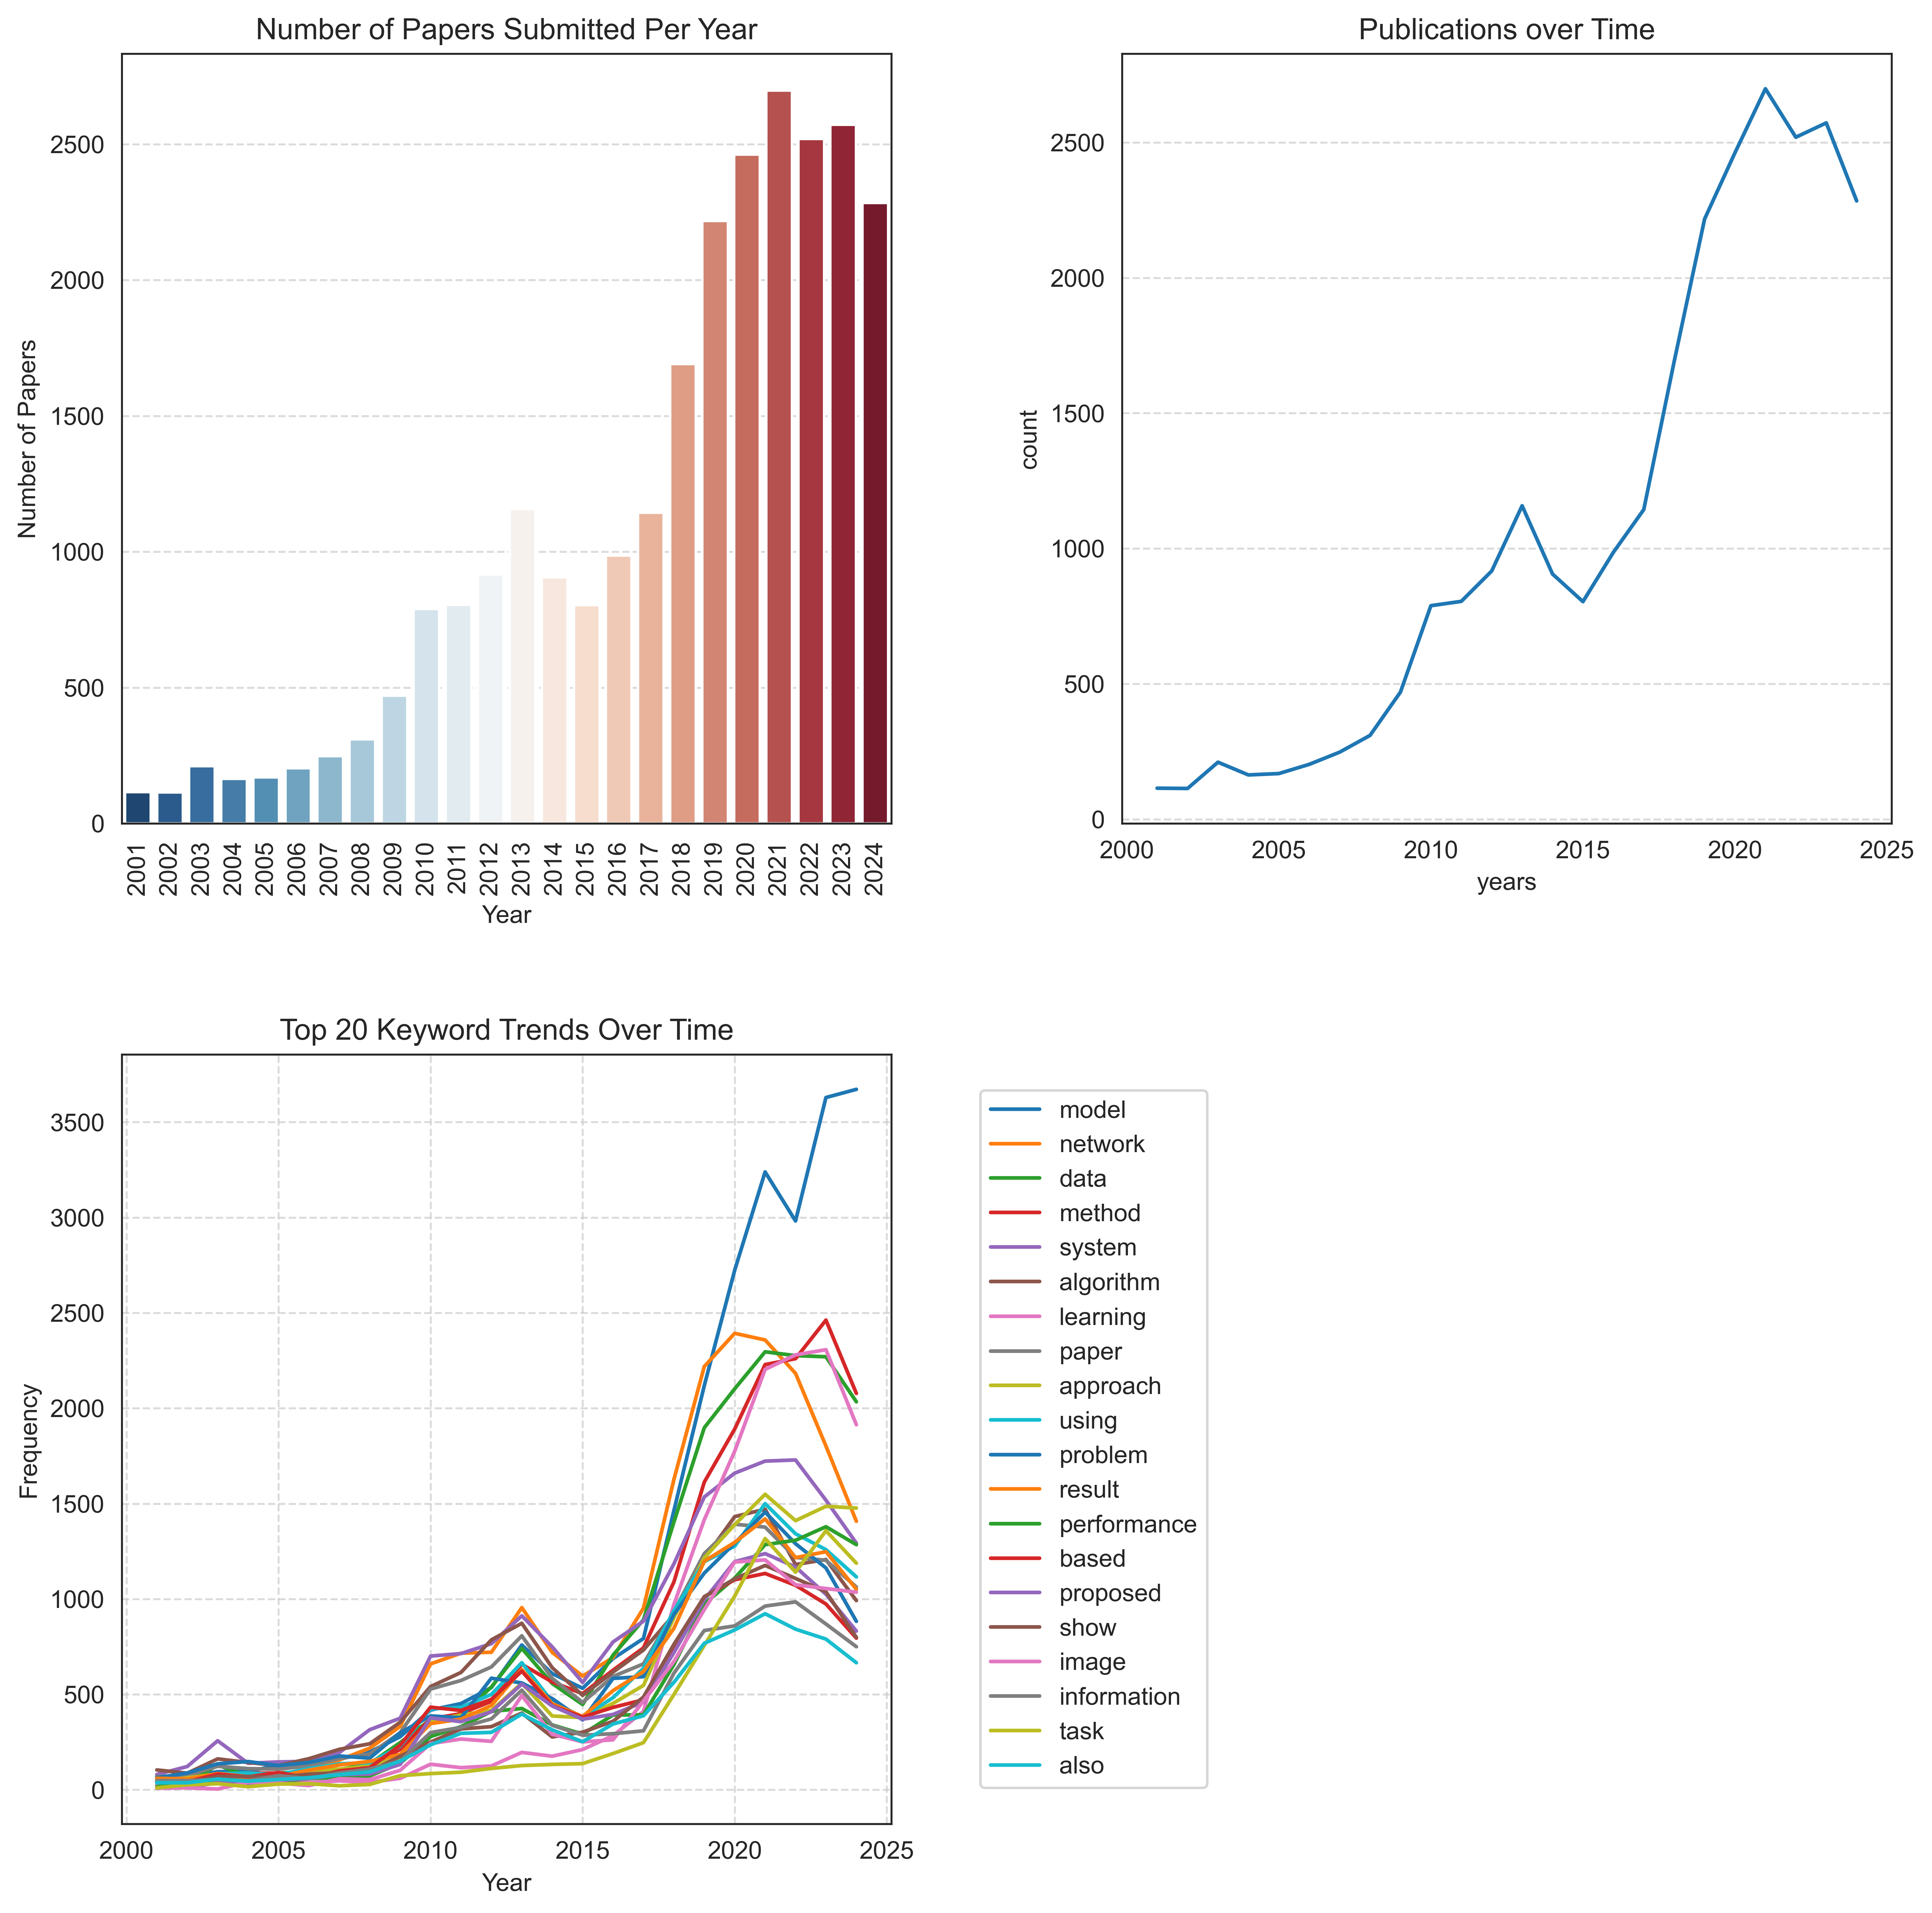

In [76]:
sns.set_style("white")
plt.figure(figsize=(10, 10), dpi=600)

# Plot submissions over time
plt.subplot(2, 2, 1)
sns.barplot(x="years", y="count", data=yearly_pub_df, palette="RdBu_r")
plt.title("Number of Papers Submitted Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Publications over Time
plt.subplot(2, 2, 2)
sns.lineplot(x="years", y="count", data=yearly_pub_df)
plt.title("Publications over Time")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Top 20 Keyword Trends Over Time
plt.subplot(2, 2, 3)
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
for keyword in top_keywords:
    if keyword in keyword_trends_df.index:
        plt.plot(keyword_trends_df.columns, keyword_trends_df.loc[keyword], label=keyword)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Top 20 Keyword Trends Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.show()

### 3.3. Temporal Topic Modeling

In [78]:
# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['abstract'])

# Apply Latent Dirichlet Allocation (LDA)
number_of_topic = 20
lda_model = LatentDirichletAllocation(n_components=number_of_topic, random_state=42)  # Set n_components = number of topics
lda_matrix = lda_model.fit_transform(tfidf_matrix)

In [79]:
# Display top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [80]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda_model, tfidf_feature_names, num_top_words=5)

Topic 0:
eeg, vqa, bcis, bci, fec
Topic 1:
learning, model, image, data, method
Topic 2:
hate, personality, aoi, sp, microservices
Topic 3:
network, energy, power, wireless, networks
Topic 4:
equilibria, nash, games, game, equilibrium
Topic 5:
rag, asd, replicas, substitutes, pdm
Topic 6:
workshop, international, proceedings, volume, papers
Topic 7:
pinns, molecular, pinn, digraph, tgp
Topic 8:
channel, codes, coding, channels, rate
Topic 9:
spam, smells, verb, ncs, verbs
Topic 10:
oss, xr, gandalf, mde, song
Topic 11:
commonsense, disinformation, analogical, backoff, lfloor
Topic 12:
chess, iiot, defeasible, rain, politeness
Topic 13:
ris, bicm, crosstalk, commutativity, fronthaul
Topic 14:
acl2, saudi, genai, font, arabia
Topic 15:
algorithm, problem, graph, matrix, linear
Topic 16:
data, model, based, systems, software
Topic 17:
capsnets, caps, artist, rsus, lombardi
Topic 18:
sos, vc, tfpie, scopus, express
Topic 19:
annotator, imputation, poi, crossbar, fatigue


### 3.4. Visualization

In [81]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, tfidf_vectorizer)
pyLDAvis.display(panel)

### 3.5. Evaluation of LDA

### 4. Model: BertTopic

### 4.1. Preprocessing

### 4.2. Exploratory Data Analysis

### 4.2. Temporal Topic Modeling

### 4.3. Visualization

### 4.4. Evaluation of BertTopic

### 5. Summary